In [1]:
# process the data to fit in the scaling model

# import all packages
import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import math
import statsmodels.formula.api as sm
from statsmodels.stats.anova import anova_lm
import geopandas as gpd

### Buildings data
### Surface and Volume from GHSL

def process_residential_builtup_volume_data():
    # reading data from multiple years
    def read_Data(path, merged_column_names, builtarea):
        df_merged = pd.DataFrame(columns = ['GEOID'])
        if builtarea == 'surface':
            divideby = 1 # area in sqmeter
        elif builtarea == 'volume':
            divideby = 1 # volume in m^3
        else:
            print('Check input format')

        merged_column_names.append(builtarea)

        pattern = os.path.join(path, f"*csv")
        for file in glob.glob(pattern):
            df = pd.read_csv(file, dtype={'GEOID':str})
            df['TOTALAREA_SQKM'] = df[['ALAND', 'AWATER']].sum(axis=1)/1000000
            df[builtarea] = df['sum']/divideby
            df = df.sort_values(by='GEOID').reset_index(drop=True)
            # print(df.columns)
            # print(file[-9:-4])
            print('Shape of the dataframe:', df.shape, 'and Total built area (volume) in squaremeters (m^3): ', df[builtarea].sum())
            df_merged = df_merged.merge(df, on='GEOID', suffixes = ('', file[-9:-4]), how = 'outer')

        return df_merged

    column_names = ['GEOID', 'NAMELSAD', 'sum']

    df_surface = read_Data(r'data\ghsl\Surface\\', column_names, 'surface')
    df_volume = read_Data(r'data\ghsl\Volume\\', column_names, 'volume')

    # To check the consecutive changes in area/ volumne in each 10 yr interval
    df_surface['change_80_90'] = (df_surface['surface_1990'] - df_surface['surface'])
    df_surface['change_90_00'] = (df_surface['surface_2000'] - df_surface['surface_1990'])
    df_surface['change_00_10'] = (df_surface['surface_2010'] - df_surface['surface_2000'])
    df_surface['change_10_20'] = (df_surface['surface_2020'] - df_surface['surface_2010'])

    df_volume['Vchange_80_90'] = (df_volume['volume_1990'] - df_volume['volume'])
    df_volume['Vchange_90_00'] = (df_volume['volume_2000'] - df_volume['volume_1990'])
    df_volume['Vchange_00_10'] = (df_volume['volume_2010'] - df_volume['volume_2000'])
    df_volume['Vchange_10_20'] = (df_volume['volume_2020'] - df_volume['volume_2010'])

    """### Non residential buildings data from GHSL for the year 2020"""

    df_non_res_S = pd.read_csv(r'data\ghsl\Non_res_surface\BuiltArea_GHSL_S_nres_2020.csv')
    df_non_res_S['GEOID'] = df_non_res_S['GEOID'].astype(str).str.rjust(7, '0')
    df_non_res_S.rename(columns = {'sum':'surface_nonRes_2020'}, inplace= True)
    df_non_res_S.columns
    df_non_res_V = pd.read_csv(r'data\ghsl\Non_res_surface\BuiltArea_GHSL_V_nres_2020.csv')
    df_non_res_V['GEOID'] = df_non_res_V['GEOID'].astype(str).str.rjust(7, '0')
    df_non_res_V.rename(columns = {'sum':'volume_nonRes_2020'}, inplace= True)
    df_non_res_V.columns

    """### Merge built are with nonResidential: Find residential only"""

    # Merge surface with volume and non residential
    # Here surface refers to total building are: res + non-res
    df = df_volume.merge(df_surface[['GEOID','surface', 'surface_1990', 'surface_1995', 'surface_2000', 'surface_2010', 'surface_2015', 'surface_2020',
                                    'change_80_90', 'change_90_00', 'change_00_10', 'change_10_20']], on = 'GEOID')
    df = df.merge(df_non_res_S[['GEOID', 'surface_nonRes_2020']], on ='GEOID')
    df = df.merge(df_non_res_V[['GEOID', 'volume_nonRes_2020']], on ='GEOID')
    df['surface_Res_2020'] = df['surface_2020'] - df['surface_nonRes_2020']
    df['volume_Res_2020'] = df['volume_2020'] - df['volume_nonRes_2020']

    # Residential height in meter
    df['height_building'] = df['volume_2020'] / df['surface_2020']
    df['floors'] = df['height_building']// 3.048

    df[['NAMELSAD','surface_2020', 'volume_2020','surface_nonRes_2020','surface_Res_2020','volume_nonRes_2020', 'volume_Res_2020']].describe()/1000

    df[df['volume_2020']/df['surface_2020'] >= 3][['NAMELSAD','surface_2020', 'volume_2020','surface_nonRes_2020','surface_Res_2020']].sort_values(by = 'surface_2020')

    print("Number of missing values in built area data: ===")
    df.isna().sum().sum()

    # Area of the place in sqkm
    df['landAreaSqkm'] = df['ALAND']/1000000
    # Percent of total area that has buildings
    df['percent_built_surface'] = df['surface_2020'] * 100/df['ALAND']

    df.isna().sum().sum()

    """### Add housing units and age from ACS"""

    df_YearBuilt = pd.read_csv(r'data\housing_data_ACS\HousingDataCleaned.csv', index_col = 0)
    df_YearBuilt['GEOID'] = df_YearBuilt['GEOID'].str[9:]

    df_YearBuilt[['GEOID','complete_plumbing', 'Year_Built']]

    df_YearBuilt[df_YearBuilt['GEOID'] == '0652582'][['GEOID', ' !!Total:', 'HUs_occupied', 'HUs_vaccant', 'NAME', 'complete_plumbing', 'Year_Built', 'Percent_Built']]

    df_YearBuilt_selected = df_YearBuilt[['GEOID', ' !!Total:', 'HUs_occupied', 'HUs_vaccant', 'NAME', 'HUs_Total', 'YB_>=_2020', 'YB_2010_2019', 'YB_2000_2009',
                'YB_1980_1999', 'YB_1960_1979', 'YB_1940_1959', 'YB_<=_1939','Year_Built', 'Percent_Built']]

    df_YearBuilt.columns

    # Area of the place in sqkm
    df['landAreaSqkm'] = df['ALAND']/1000000
    # Percent of total area that has buildings
    df['percent_built_surface'] = df['surface_2020'] * 100/df['ALAND']

    df.isna().sum().sum()

    """### Merge with surface-volume with HUs and age"""

    df_buildings = df.merge(df_YearBuilt_selected, on = 'GEOID')

    # get an weighted age for each place
    df_buildings['weighted_avg_age'] = ((2024-1939)*df_buildings['YB_<=_1939'] + (2024-1950)*df_buildings['YB_1940_1959'] + (2024-1970)*df_buildings['YB_1960_1979'] +
                                    (2024-1990)*df_buildings['YB_1980_1999'] + (2024-2004)*df_buildings['YB_2000_2009'] + (2024-2014)*df_buildings['YB_2010_2019'] +
                                    (2024-2022)*df_buildings['YB_>=_2020'])/100

    df_buildings[['STATEFP', 'NAMELSAD','YB_>=_2020','YB_2010_2019', 'YB_2000_2009', 'Year_Built', 'Percent_Built', 'weighted_avg_age']].isna().sum()

    """### Import population and attributes data from depopulation study"""

    df_population = pd.read_csv(r'data\population\forecasted_trend.csv', index_col  = 0)
    df_population['GEOID'] = df_population['GEOID'].astype(str).str.rjust(7,'0')

    df_attributes = pd.read_csv(r'data\population\df_attributes.csv', index_col  = 0)
    df_attributes['GEOID'] = df_attributes['GEOID'].astype(str).str.rjust(7,'0')

    df_pop_attr = df_population.merge(df_attributes[['GEOID', 'REGION', 'city type', 'weighted_HU_density_sqmi',
                                                    'ua-to-place allocation factor_max', 'population_ua_min',
                                                    'population_ua_max', 'median_income']], on = 'GEOID')

    df_attributes.shape, df_population.shape

    df_attributes.columns

    df_population[(df_population['ssp42020'] -df_population['CensusPop_20']) > 0][['NAMELSAD', 'CensusPop_20','ssp22020', 'ssp22030', 'ssp22040',
                                                                                'ssp22050', 'ssp22060','ssp22070', 'ssp22080', 'ssp22090', 'ssp22100']]

    df_population[['ssp22020', 'ssp22030', 'ssp22040', 'ssp22050','ssp22060', 'ssp22070', 'ssp22080', 'ssp22090','ssp22100', 'ssp12020', 'ssp12030', 'ssp12040', 'ssp12050', 'ssp12060','ssp12070',
                    'ssp12080', 'ssp12090', 'ssp12100', 'ssp42020', 'ssp42030', 'ssp42040', 'ssp42050', 'ssp42060','ssp42070', 'ssp42080', 'ssp42090',
                    'ssp42100']] =df_population[['ssp22020', 'ssp22030', 'ssp22040', 'ssp22050','ssp22060', 'ssp22070', 'ssp22080', 'ssp22090','ssp22100', 'ssp12020', 'ssp12030', 'ssp12040', 'ssp12050',
                    'ssp12060','ssp12070','ssp12080', 'ssp12090', 'ssp12100', 'ssp42020', 'ssp42030', 'ssp42040', 'ssp42050', 'ssp42060', 'ssp42070', 'ssp42080', 'ssp42090', 'ssp42100']].round(0)

    # Total population for SSP 2 for each 10 yr interval
    print('Total population in millions for 51 states: ===')
    df_population[['CensusPop_20','ssp22020', 'ssp22030', 'ssp22040', 'ssp22050', 'ssp22060','ssp22070', 'ssp22080', 'ssp22090', 'ssp22100']].sum() / 1000000

    """### Merge buildings with population"""

    building_with_pop_all = df_buildings.merge(df_pop_attr[['GEOID', 'State', 'REGION', 'ua-to-place allocation factor_max', 'population_ua_min',
                                                        'population_ua_max','label', 'future trend from SSP 2', 'CensusPop_20', 'city type','weighted_HU_density_sqmi','median_income',
                                                    'ssp22020', 'ssp22030', 'ssp22040', 'ssp22050','ssp22060', 'ssp22070', 'ssp22080',
                                                    'ssp22090','ssp22100', 'ssp12020', 'ssp12030', 'ssp12040', 'ssp12050', 'ssp12060','ssp12070',
                                                    'ssp12080', 'ssp12090', 'ssp12100', 'ssp42020', 'ssp42030', 'ssp42040', 'ssp42050', 'ssp42060',
                                                    'ssp42070', 'ssp42080', 'ssp42090', 'ssp42100']], on = 'GEOID', how='left')

    building_with_pop_all[building_with_pop_all['GEOID'].str.startswith('214800')][['GEOID', 'NAMELSAD','CensusPop_20', 'ssp22020', 'ssp22030', 'ssp22040', 'ssp22050']]

    building_with_pop_all.shape, df_buildings.shape, df_population.shape, df_attributes.shape

    building_with_pop_all[['CensusPop_20','ssp22020', 'ssp22030', 'ssp22040', 'ssp22050','ssp22060', 'ssp22070', 'ssp22080','ssp22090','ssp22100',
                        'ssp12020', 'ssp12030', 'ssp12040', 'ssp12050', 'ssp12060','ssp12070', 'ssp12080', 'ssp12090', 'ssp12100','ssp42020',
                        'ssp42030', 'ssp42040', 'ssp42050', 'ssp42060','ssp42070', 'ssp42080', 'ssp42090', 'ssp42100']].isna().sum().sum()

    building_with_pop_all['percentchangeinpop'] = np.abs((building_with_pop_all['ssp42020'] - building_with_pop_all['CensusPop_20'])/building_with_pop_all['CensusPop_20'])

    print("Shape of building dataframe", building_with_pop_all.shape[0])
    print("No of places within 1% variation in 2020 census population and ssp scenario 1, 2 and 4")
    print("ssp1", building_with_pop_all[np.abs((building_with_pop_all['ssp12020'] - building_with_pop_all['CensusPop_20'])/building_with_pop_all['CensusPop_20']) < 0.01].shape[0])
    print("ssp2", building_with_pop_all[np.abs((building_with_pop_all['ssp22020'] - building_with_pop_all['CensusPop_20'])/building_with_pop_all['CensusPop_20']) < 0.01].shape[0])
    print("ssp4", building_with_pop_all[np.abs((building_with_pop_all['ssp42020'] - building_with_pop_all['CensusPop_20'])/building_with_pop_all['CensusPop_20']) < 0.01].shape[0])
    print("No of places over 1% variation in 2020 census population and ssp scenario 1, 2 and 4")
    print("ssp1", building_with_pop_all[np.abs((building_with_pop_all['ssp12020'] - building_with_pop_all['CensusPop_20'])/building_with_pop_all['CensusPop_20']) >= 0.01].shape[0])
    print("ssp2", building_with_pop_all[np.abs((building_with_pop_all['ssp22020'] - building_with_pop_all['CensusPop_20'])/building_with_pop_all['CensusPop_20']) >= 0.01].shape[0])
    print("ssp4", building_with_pop_all[np.abs((building_with_pop_all['ssp42020'] - building_with_pop_all['CensusPop_20'])/building_with_pop_all['CensusPop_20']) >= 0.01].shape[0])
    print("No of places over 5% variation in 2020 census population and ssp scenario 1, 2 and 4")
    print("ssp1", building_with_pop_all[np.abs((building_with_pop_all['ssp12020'] - building_with_pop_all['CensusPop_20'])/building_with_pop_all['CensusPop_20']) >= 0.05].shape[0])
    print("ssp2", building_with_pop_all[np.abs((building_with_pop_all['ssp22020'] - building_with_pop_all['CensusPop_20'])/building_with_pop_all['CensusPop_20']) >= 0.05].shape[0])
    print("ssp4", building_with_pop_all[np.abs((building_with_pop_all['ssp42020'] - building_with_pop_all['CensusPop_20'])/building_with_pop_all['CensusPop_20']) >= 0.05].shape[0])

    # excluding cities that varies over 10% in population forecast in 2020 for ssp4
    building_with_pop = building_with_pop_all[(building_with_pop_all['percentchangeinpop'] <=.01)]

    # building_with_pop[building_with_pop['city type'] == 'not enough data'].head() #shape[0] # ['CensusPop_20'].sum()

    building_with_pop.groupby('city type')[['Percent_Built','weighted_HU_density_sqmi']].describe()

    building_with_pop['weighted_HU_density_sqmi'].isna().sum()

    condition = building_with_pop[' !!Total:'] != 0
    building_with_pop.loc[condition,'HU_density_sqmile'] = building_with_pop[' !!Total:'] / (3.86102e-7 * building_with_pop['ALAND'])
    building_with_pop.loc[condition,'avg_HU_size_Res_sqm'] = (building_with_pop['volume_Res_2020'] / building_with_pop[' !!Total:']) # measures avg res unit volume

    building_with_pop[['weighted_HU_density_sqmi','HU_density_sqmile','avg_HU_size_Res_sqm']].describe()

    print(building_with_pop.shape)

    return building_with_pop

In [2]:
building_with_pop = process_residential_builtup_volume_data()

Shape of the dataframe: (32188, 8) and Total built area (volume) in squaremeters (m^3):  21644923940.827446
Shape of the dataframe: (32188, 8) and Total built area (volume) in squaremeters (m^3):  24308169725.54902
Shape of the dataframe: (32188, 8) and Total built area (volume) in squaremeters (m^3):  27090809701.21176
Shape of the dataframe: (32188, 8) and Total built area (volume) in squaremeters (m^3):  30132932830.333332
Shape of the dataframe: (32188, 8) and Total built area (volume) in squaremeters (m^3):  34211558949.564705
Shape of the dataframe: (32188, 8) and Total built area (volume) in squaremeters (m^3):  36204795388.78432
Shape of the dataframe: (32188, 8) and Total built area (volume) in squaremeters (m^3):  37375579106.32157
Shape of the dataframe: (32188, 8) and Total built area (volume) in squaremeters (m^3):  157313248400.5608
Shape of the dataframe: (32188, 8) and Total built area (volume) in squaremeters (m^3):  173143434872.09802
Shape of the dataframe: (32188, 8

C:\Users\uttar\AppData\Local\Temp\ipykernel_18340\2632400463.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_with_pop.loc[condition,'HU_density_sqmile'] = building_with_pop[' !!Total:'] / (3.86102e-7 * building_with_pop['ALAND'])
C:\Users\uttar\AppData\Local\Temp\ipykernel_18340\2632400463.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_with_pop.loc[condition,'avg_HU_size_Res_sqm'] = (building_with_pop['volume_Res_2020'] / building_with_pop[' !!Total:']) # measures avg res unit

In [3]:
building_with_pop[[' !!Total:', 'HUs_occupied', 'HUs_vaccant', 'HUs_Total',]].sum()

 !!Total:       105018300.0
HUs_occupied     95676879.0
HUs_vaccant       9341421.0
HUs_Total        93990067.0
dtype: float64

In [4]:
building_with_pop['avg_HU_size_Res_sqm'].describe()

count     30772.000000
mean       2000.977482
std        5412.719392
min           0.000000
25%        1267.854755
50%        1663.456848
75%        2164.132529
max      344299.263434
Name: avg_HU_size_Res_sqm, dtype: float64

In [17]:
building_with_pop['avg_HU_size_Res_sqm'].quantile([0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.995])

0.010     380.329257
0.050     800.553771
0.100     975.491975
0.250    1267.854755
0.500    1663.456848
0.750    2164.132529
0.900    2727.494515
0.950    3170.463239
0.990    5225.687228
0.995    7812.248977
Name: avg_HU_size_Res_sqm, dtype: float64

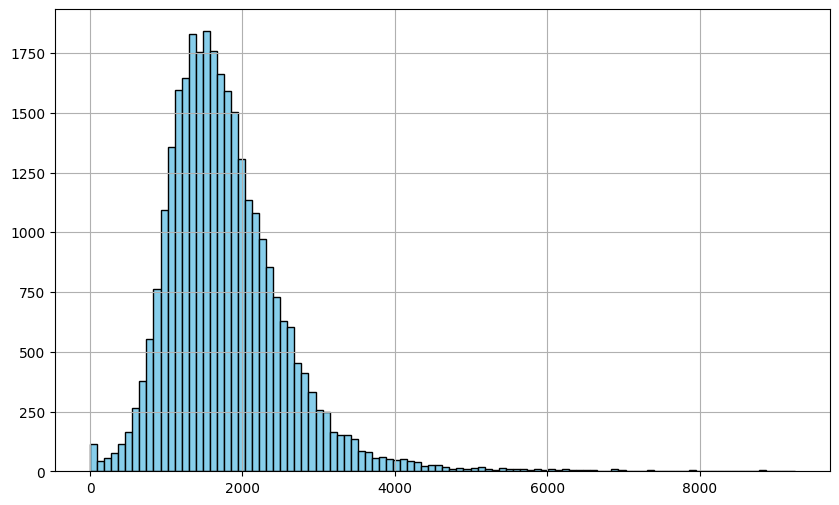

In [18]:
building_with_pop[building_with_pop['avg_HU_size_Res_sqm']<10000]['avg_HU_size_Res_sqm'].hist(bins=100, figsize=(10, 6), color='skyblue', edgecolor='black')
plt.show()


In [5]:
building_with_pop['avg_HU_size_Res_sqm'].mean(), building_with_pop['avg_HU_size_Res_sqm'].median(), building_with_pop['avg_HU_size_Res_sqm'].std()

(2000.9774818415049, 1663.4568478086876, 5412.719391507159)

In [6]:
202929927010.6588/1663,202929927010.6588/2000, 239691281982.5797/2000, 187*4.6*2.6

(122026414.31789465, 101464963.5053294, 119845640.99128985, 2236.52)